In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
np.random.seed(seed=1234)

In [2]:
# AWS_Food_Reviews.csv 데이터를 데이터프레임에 저장 (3만개의 행(rows)만 추출)
data = pd.read_csv("AWS_Food_Reviews.csv", nrows = 30000)
print('전체 리뷰 개수 :',(len(data)))

전체 리뷰 개수 : 30000


In [3]:
print(data.head())
data = data[['Text','Summary']]
print(data.head())

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

In [4]:
# Summary는 중복이 더 많지만, 원문은 다르더라도 짧은 문장인 요약은 내용이 겹칠 수 있음을 가정
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())
print(data.isnull().sum())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 28677
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 24651
Text       0
Summary    0
dtype: int64


In [5]:
# text 열에서 중복인 내용이 있다면 중복 제거
data.drop_duplicates(subset=['Text'], inplace=True)
print("전체 샘플수 :", len(data))

전체 샘플수 : 28677


In [6]:
# 단어(약어) 정규화 및 불용어 제거 :
# 동일한 의미를 가졌지만 스펠링이 다른 단어들을 정규화하기 위한 사전
# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = {
"'cause": 'because',
 "I'd": 'I would',
 "I'd've": 'I would have',
 "I'll": 'I will',
 "I'll've": 'I will have',
 "I'm": 'I am',
 "I've": 'I have',
 "ain't": 'is not',
 "aren't": 'are not',
 "can't": 'cannot',
 "could've": 'could have',
 "couldn't": 'could not',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 "hadn't": 'had not',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he'd": 'he would',
 "he'll": 'he will',
 "he's": 'he is',
 "here's": 'here is',
 "how'd": 'how did',
 "how'd'y": 'how do you',
 "how'll": 'how will',
 "how's": 'how is',
 "i'd": 'i would',
 "i'd've": 'i would have',
 "i'll": 'i will',
 "i'll've": 'i will have',
 "i'm": 'i am',
 "i've": 'i have',
 "isn't": 'is not',
 "it'd": 'it would',
 "it'd've": 'it would have',
 "it'll": 'it will',
 "it'll've": 'it will have',
 "it's": 'it is',
 "let's": 'let us',
 "ma'am": 'madam',
 "mayn't": 'may not',
 "might've": 'might have',
 "mightn't": 'might not',
 "mightn't've": 'might not have',
 "must've": 'must have',
 "mustn't": 'must not',
 "mustn't've": 'must not have',
 "needn't": 'need not',
 "needn't've": 'need not have',
 "o'clock": 'of the clock',
 "oughtn't": 'ought not',
 "oughtn't've": 'ought not have',
 "sha'n't": 'shall not',
 "shan't": 'shall not',
 "shan't've": 'shall not have',
 "she'd": 'she would',
 "she'd've": 'she would have',
 "she'll": 'she will',
 "she'll've": 'she will have',
 "she's": 'she is',
 "should've": 'should have',
 "shouldn't": 'should not',
 "shouldn't've": 'should not have',
 "so's": 'so as',
 "so've": 'so have',
 "that'd": 'that would',
 "that'd've": 'that would have',
 "that's": 'that is',
 "there'd": 'there would',
 "there'd've": 'there would have',
 "there's": 'there is',
 "they'd": 'they would',
 "they'd've": 'they would have',
 "they'll": 'they will',
 "they'll've": 'they will have',
 "they're": 'they are',
 "they've": 'they have',
 "this's": 'this is',
 "to've": 'to have',
 "wasn't": 'was not',
 "we'd": 'we would',
 "we'd've": 'we would have',
 "we'll": 'we will',
 "we'll've": 'we will have',
 "we're": 'we are',
 "we've": 'we have',
 "weren't": 'were not',
 "what'll": 'what will',
 "what'll've": 'what will have',
 "what're": 'what are',
 "what's": 'what is',
 "what've": 'what have',
 "when's": 'when is',
 "when've": 'when have',
 "where'd": 'where did',
 "where's": 'where is',
 "where've": 'where have',
 "who'll": 'who will',
 "who'll've": 'who will have',
 "who's": 'who is',
 "who've": 'who have',
 "why's": 'why is',
 "why've": 'why have',
 "will've": 'will have',
 "won't": 'will not',
 "won't've": 'will not have',
 "would've": 'would have',
 "wouldn't": 'would not',
 "wouldn't've": 'would not have',
 "y'all": 'you all',
 "y'all'd": 'you all would',
 "y'all'd've": 'you all would have',
 "y'all're": 'you all are',
 "y'all've": 'you all have',
 "you'd": 'you would',
 "you'd've": 'you would have',
 "you'll": 'you will',
 "you'll've": 'you will have',
 "you're": 'you are',
 "you've": 'you have'
}

# NLTK 모듈 내 불용어
stop_words = set(stopwords.words('english'))
print('불용어 개수 :', len(stop_words))
print(stop_words)

불용어 개수 : 179
{'very', "you'd", 'nor', 't', "couldn't", 'both', 'me', "isn't", 'again', 'yourself', "mightn't", 'our', 'your', "that'll", 'because', "should've", 've', 'before', 'once', 'each', 'mustn', 'more', 'don', 'was', 'to', 'those', 'an', 'how', 'than', "mustn't", 'weren', 'below', "you're", 'whom', 'then', 'needn', 'not', 'with', 'out', 'were', 'can', 'you', 'being', 'ourselves', 'other', 'into', "she's", 'why', 'hadn', 'y', 'his', "you'll", 'no', 'theirs', "hasn't", 'has', 'doesn', 'didn', "doesn't", 'about', 'further', 'between', "don't", 'o', 'from', "needn't", 'ain', "hadn't", 'this', 'in', 'him', 'am', 'itself', "weren't", 'its', 'wasn', 'will', "aren't", 'most', 're', 'few', 'if', 'now', 'by', 'yours', 'ours', 'any', 'which', 'all', 'couldn', "wasn't", 'until', 'doing', 'after', 'have', 'where', 'm', 'a', 'myself', 'for', 'do', 'ma', 'the', 'so', "haven't", 'herself', 'is', 'hasn', 'shouldn', 'as', "won't", 'yourselves', "shouldn't", 'too', "didn't", 'he', 'won', 'haven', 

In [7]:
# 전처리 함수
import re # Regular expression operation module
def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열  제거, eg. my husband (and myself) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 단어(약어) 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거, eg. roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경, eg. ummmmmmm yeah -> umm yeah

    if remove_stopwords: # 불용어 제거 (Text)
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    else: # 불용어 미제거 (Summary), ie. remove_stopwords = False
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [8]:
# 전처리 테스트
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'
print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [9]:
# Text 열 전처리
clean_text = []
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))
print(clean_text[:5])

# Summary 열 전처리
clean_summary = []
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))
print(clean_summary[:5])

# 전처리 후의 결과를 다시 데이터프레임에 저장
data['Text'] = clean_text
data['Summary'] = clean_summary

# 길이가 공백인 샘플은 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print(data.isnull().sum())

# Null 값을 가지는 샘플 제거
data.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(data)))

C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better', 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo', 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch', 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal', 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']
['good quality dog food', 'not as advertised', 'delight says it all', 'cough medicine', 'great taffy']
Text        0
Summary    25
dtype: int64
전체 샘플수 : 28652


텍스트의 최소 길이 : 4
텍스트의 최대 길이 : 863
텍스트의 평균 길이 : 37.92873097864023
요약의 최소 길이 : 1
요약의 최대 길이 : 25
요약의 평균 길이 : 3.983770766438643


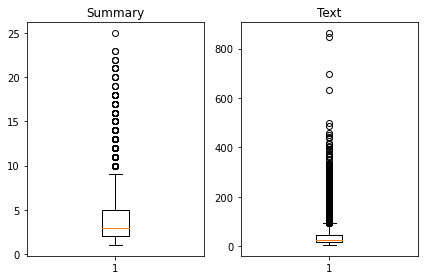

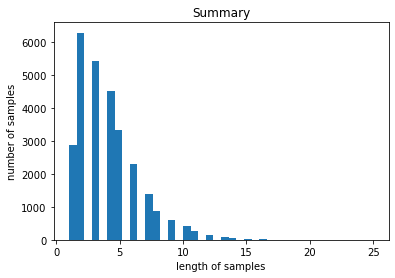

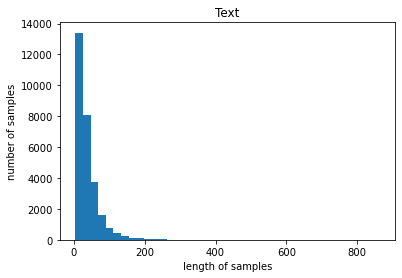

In [10]:
# 하이퍼파라미터 조정을 위한 길이 분포 출력
text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [11]:
# 하이퍼파라미터 : 텍스트 길이 = 평균보다 약간 큰 값으로 결정
text_max_len = 50
summary_max_len = 8

# Text 및 Summary 길이가 위에 정한 최대 길이보다 큰 샘플들 제거
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))
print(data.head())

전체 샘플수 : 21567
                                                Text                Summary
0  bought several vitality canned dog food produc...  good quality dog food
1  product arrived labeled jumbo salted peanuts p...      not as advertised
2  confection around centuries light pillowy citr...    delight says it all
3  looking secret ingredient robitussin believe f...         cough medicine
4  great taffy great price wide assortment yummy ...            great taffy


In [12]:
# seq2seq 학습을 위해 디코더 입력 및 레이블에 시작 토큰과 종료 토큰 추가
# 시작 토큰 'sostoken', 종료 토큰 'eostoken'을 사용하고 문장 앞뒤에 추가
# 요약 데이터에 시작 토큰과 종료 토큰 추가
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
print(data.head())

# 인코더의 입력, 그리고 토큰 추가된 디코더의 입력 및 레이블을 각각 저장
encoder_input = np.array(data['Text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

                                                Text                Summary  \
0  bought several vitality canned dog food produc...  good quality dog food   
1  product arrived labeled jumbo salted peanuts p...      not as advertised   
2  confection around centuries light pillowy citr...    delight says it all   
3  looking secret ingredient robitussin believe f...         cough medicine   
4  great taffy great price wide assortment yummy ...            great taffy   

                    decoder_input                  decoder_target  
0  sostoken good quality dog food  good quality dog food eostoken  
1      sostoken not as advertised      not as advertised eostoken  
2    sostoken delight says it all    delight says it all eostoken  
3         sostoken cough medicine         cough medicine eostoken  
4            sostoken great taffy            great taffy eostoken  


In [13]:
# 훈련 데이터와 테스트 데이터를 분리
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# 랜덤하게 섞인 데이터를 8:2의 비율로
# 훈련 데이터와 테스트 데이터로 분리
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

[13464  5041  3181 ...  8471 17048  1318]
테스트 데이터의 수 : 4313
훈련 데이터의 개수 : 17254
훈련 레이블의 개수 : 17254
테스트 데이터의 개수 : 4313
테스트 레이블의 개수 : 4313


In [14]:
# 텍스트 벡터화

# 텍스트 시퀀스를 정수 시퀀스로 변환
src_vocab = 8000
src_tokenizer = Tokenizer(src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

encoded_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoded_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)
print(encoded_input_train[:5])

# 요약 시퀀스를 정수 시퀀스로 변환
tar_vocab = 2000
tar_tokenizer = Tokenizer(tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

decoded_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoded_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoded_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoded_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)
print(decoded_input_train[:5])

[[313, 577, 335, 37, 55, 150, 431, 469, 1982, 255, 63, 504, 537, 471, 240, 648, 297, 242, 9, 122, 1], [67, 47, 32, 45, 111, 1316, 63, 34, 1015], [7, 203, 643, 263, 418, 573, 1897, 14, 8, 38, 159, 240, 471, 159, 48, 37, 1296, 32, 677, 48, 197, 110, 196, 71, 1130, 800, 91, 43, 1093, 3128, 193, 9, 212, 573, 2568, 432, 218, 1897, 4206, 2, 121, 237], [2, 16, 191, 3945, 1450, 3685, 5608, 2083, 147, 37, 308, 2036, 5609, 1250, 1, 5610, 415, 241, 1768, 1250, 78, 163, 951, 16, 3492, 4556, 2, 6, 10, 42, 258], [2, 1297, 538, 3, 255, 737, 446, 547, 2, 99, 1530, 115, 415, 2, 367, 2142, 29]]
[[1, 171, 195, 1311], [1, 48, 226, 351, 4], [1, 9, 501, 817], [1, 25, 80], [1, 3, 227]]


In [15]:
# 참고 : 등장 빈도수가 7회 미만인 단어들이 얼만큼의 비중을 차지하는지 확인
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받음
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작을경우
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('소스 단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받음
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작을경우
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('타겟 단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

소스 단어 집합(vocabulary)의 크기 : 18295
등장 빈도가 6번 이하인 희귀 단어의 수: 13740
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 4555
단어 집합에서 희귀 단어의 비율: 75.10248701831101
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.249031157960006
타겟 단어 집합(vocabulary)의 크기 : 5655
등장 빈도가 6번 이하인 희귀 단어의 수: 4099
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 1556
단어 집합에서 희귀 단어의 비율: 72.48452696728559
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.532919451144767


In [16]:
# 만약 전체 데이터에서 빈도수가 낮은 단어들을 삭제했을 경우
# 빈도수가 낮은 단어만으로 구성되었던 샘플들은 빈(empty) 샘플이 됨
# 요약문의 경우 sostoken, eostoken이 추가됨, 빈 요약문의 실질적 길이는 1
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoded_input_train = np.delete(encoded_input_train, drop_train, axis=0)
decoded_input_train = np.delete(decoded_input_train, drop_train, axis=0)
decoded_target_train = np.delete(decoded_target_train, drop_train, axis=0)

encoded_input_test = np.delete(encoded_input_test, drop_test, axis=0)
decoded_input_test = np.delete(decoded_input_test, drop_test, axis=0)
decoded_target_test = np.delete(decoded_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoded_input_train))
print('훈련 레이블의 개수 :',len(decoded_input_train))
print('테스트 데이터의 개수 :',len(encoded_input_test))
print('테스트 레이블의 개수 :',len(decoded_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 17254
훈련 레이블의 개수 : 17254
테스트 데이터의 개수 : 4313
테스트 레이블의 개수 : 4313


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [17]:
# 최대 길이에 맞추어 훈련 데이터와 테스트 데이터에 대해서 패딩 작업을 수행
encoded_input_train = pad_sequences(encoded_input_train, maxlen = text_max_len, padding='post')
encoded_input_test = pad_sequences(encoded_input_test, maxlen = text_max_len, padding='post')
decoded_input_train = pad_sequences(decoded_input_train, maxlen = summary_max_len, padding='post')
decoded_target_train = pad_sequences(decoded_target_train, maxlen = summary_max_len, padding='post')
decoded_input_test = pad_sequences(decoded_input_test, maxlen = summary_max_len, padding='post')
decoded_target_test = pad_sequences(decoded_target_test, maxlen = summary_max_len, padding='post')

print(encoded_input_train[:5])
print(decoded_input_train[:5])

[[ 313  577  335   37   55  150  431  469 1982  255   63  504  537  471
   240  648  297  242    9  122    1    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [  67   47   32   45  111 1316   63   34 1015    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   7  203  643  263  418  573 1897   14    8   38  159  240  471  159
    48   37 1296   32  677   48  197  110  196   71 1130  800   91   43
  1093 3128  193    9  212  573 2568  432  218 1897 4206    2  121  237
     0    0    0    0    0    0    0    0]
 [   2   16  191 3945 1450 3685 5608 2083  147   37  308 2036 5609 1250
     1 5610  415  241 1768 1250   78  163  951   16 3492 4556    2    6
    10   42  258    0    0    0    0    0    0    0    0    0    0    0
     0 

In [18]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 128
hidden_size = 256

# 인코더 설계 : LSTM 층 3개
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

'''
# 디코더의 출력층 : 어텐션을 사용하지 않을경우
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()
'''

"\n# 디코더의 출력층 : 어텐션을 사용하지 않을경우\ndecoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')\ndecoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) \n\n# 모델 정의\nmodel = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)\nmodel.summary()\n"

In [19]:
# importing attention layer (바다나우 어텐션)
import tensorflow as tf
import os
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

# This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
class AttentionLayer(Layer):

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층 : 어텐션을 사용 할 경우
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 128)      1024000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 50, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

In [22]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

# patience 옵션을 2로 설정 : 모델 학습 시 성능이 개선되지 않는 횟수가 2회를 초과하면 학습을 멈춤
earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoded_input_train, decoded_input_train], y = decoded_target_train, \
          validation_data = ([encoded_input_test, decoded_input_test], decoded_target_test), \
          batch_size = 256, callbacks=[earlystop], epochs = 1)

68/68 [==============================] - 772s 11s/step - loss: 2.8168 - val_loss: 2.4787


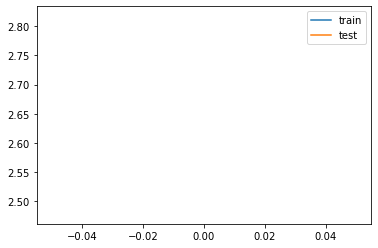

In [26]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [27]:
# 테스트 용 seq2seq + attention 요약 모델
# seq2seq는 훈련 단계와 테스트 단계의 동작이 다르므로 테스트 단계의 모델을 별도로 다시 설계할 필요가 있음

# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용, 이는 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [31]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    sentence=''
    for i in input_seq:
        if(i!=0):
            sentence = sentence + src_index_to_word[i]+' '
    return sentence

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    sentence=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            sentence = sentence + tar_index_to_word[i] + ' '
    return sentence

# 테스트 샘플 중 100번부터 110번까지 실제/예측 요약문 비교
for i in range(100, 110):
    print("원문 :",seq2text(encoded_input_test[i]))
    print("실제 요약문 :",seq2summary(decoded_input_test[i]))
    print("예측 요약문 :",decode_sequence(encoded_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : chili recipe great find husband loved easy make liked recommend 
실제 요약문 : we loved this chili recipe 
예측 요약문 :  great


원문 : several relatives dietary restrictions family including gluten dairy sensitivity happy try pamela oat chocolate chip coconut snack bars taste good well balanced chocolate coconut flavors pleasant moist consistency similar oat bars tried since gluten dairy free everyone family enjoy without worrying effects update like much reorder family friends recommended cfh 
실제 요약문 : very good tasting snack bars recommended 
예측 요약문 :  great


원문 : look tasty candy freak try say least extremely dissapointed chemical taste texture like chewing glue nasty would never eat buy goes flavors 
실제 요약문 : 
예측 요약문 :  great


원문 : made potato bread great results hodgson bread mix way dry needs moisture buy unless want really dry bread 
실제 요약문 : potato bread 
예측 요약문 :  great


원문 : dog love busy buddy bottle fill dog food treats spends lots time floor get treats eat rope top right awa

In [30]:
# ChatGPT : Please write the sample code using bart model in keras.
# Sure, here's some sample code using the BART model in Keras:
from transformers import BartTokenizer, TFBartForConditionalGeneration

# Load the tokenizer and BART model
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
model = TFBartForConditionalGeneration.from_pretrained('facebook/bart-large')

# Define your input text and encode it using the tokenizer
input_text = "Some input text for summarization."
input_ids = tokenizer.encode(input_text, return_tensors='tf')

# Generate a summary using the BART model
summary_ids = model.generate(input_ids)

# Decode the summary and print it
summary_text = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print(summary_text)

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBartForConditionalGeneration.

All the layers of TFBartForConditionalGeneration were initialized from the model checkpoint at facebook/bart-large.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


Some input text for summarization.


In [ ]:
# ChatGPT : How to fine-tune the model in additinal to the above code?
'''
To fine-tune a BART model, you can follow the same approach as with any other transformer model. Here's a high-level overview of the steps:

Load the pre-trained BART model using transformers.BartForConditionalGeneration.
Prepare your data by tokenizing your text and converting it to input features that the model can process.
Fine-tune the model on your task-specific data using Keras' model.fit method or custom training loop.
Evaluate the fine-tuned model on a validation set to check its performance.
Here's some sample code that fine-tunes a pre-trained BART model on a summarization task:
'''
import transformers
import tensorflow as tf

# Load pre-trained BART model
model = transformers.BartForConditionalGeneration.from_pretrained('facebook/bart-large')

# Prepare data
tokenizer = transformers.BartTokenizer.from_pretrained('facebook/bart-large')

train_texts = ['train text 1', 'train text 2', ...]
train_summaries = ['train summary 1', 'train summary 2', ...]

val_texts = ['val text 1', 'val text 2', ...]
val_summaries = ['val summary 1', 'val summary 2', ...]

max_length = 1024

# Preparing the data by tokenizing the input and summary texts using transformers.
# BartTokenizer and converting them to input features that the model can process.
train_encodings = tokenizer(train_texts, train_summaries, truncation=True, max_length=max_length)
val_encodings = tokenizer(val_texts, val_summaries, truncation=True, max_length=max_length)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_encodings['input_ids']
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_encodings['input_ids']
))

# Fine-tune the model
optimizer = transformers.AdamW(model.parameters(), lr=1e-5)

model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])

model.fit(
    train_dataset.shuffle(10000).batch(8), epochs=3, batch_size=16,
    validation_data = val_dataset.shuffle(10000).batch(16),
)

# Evaluate the fine-tuned model
model.evaluate(val_dataset.shuffle(10000).batch(16))

# Save the model in HDF5 format
model.save('fine_tuned_bart.h5')

In [ ]:
# ChatGPT : How to get the predicted result in additinal to the above code?
# To get the predicted results after fine-tuning the BART model in the above,
# you can use the predict method of the Keras model. Here's an example:

# Assume that you have fine-tuned the BART model and saved it as `fine_tuned_bart.h5`
# Load the fine-tuned BART model
model = TFBartForConditionalGeneration.from_pretrained('facebook/bart-large')
model.load_model('fine_tuned_bart.h5')

# Assume that you have a list of input texts named `input_texts`
# Convert the input texts into features using the tokenizer
inputs = tokenizer.batch_encode_plus(input_texts, return_tensors='tf', padding=True, truncation=True, max_length=512)

# Get the model predictions
outputs = model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'])

# Decode the model predictions back into text
output_texts = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]